## Import libraries:

In [1]:
from imports import *

## 1. Preprocessing

The data corresponds to the Monte Carlo simulation of the SBND experiment. It was obtained by simulating the creation of neutrinos in the beam and their subsequent interaction in SBND, as well as the simulation of the detector's response to the particles resulting from the interaction of the neutrinos.

In [2]:
file_path = '/data/vidales/opana_tree_combined_v0411_both.root'
file = uproot.open(file_path)
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
print("Keys in optree:", optree.keys())

Keys in optree: ['eventID', 'runID', 'subrunID', 'nuvX', 'nuvY', 'nuvZ', 'nuvT', 'nuvE', 'stepX', 'stepY', 'stepZ', 'stepT', 'dE', 'energydep', 'energydepX', 'energydepY', 'energydepZ', 'E', 'StartPx', 'StartPy', 'StartPz', 'EndPx', 'EndPy', 'EndPz', 'process', 'trackID', 'motherID', 'PDGcode', 'InTimeCosmics', 'InTimeCosmicsTime', 'dEtpc', 'dEpromx', 'dEpromy', 'dEpromz', 'dEspreadx', 'dEspready', 'dEspreadz', 'dElowedges', 'dEmaxedges', 'nopflash', 'flash_id', 'flash_time', 'flash_total_pe', 'flash_pe_v', 'flash_tpc', 'flash_y', 'flash_yerr', 'flash_z', 'flash_zerr', 'flash_x', 'flash_xerr', 'flash_ophit_time', 'flash_ophit_risetime', 'flash_ophit_starttime', 'flash_ophit_amp', 'flash_ophit_area', 'flash_ophit_width', 'flash_ophit_pe', 'flash_ophit_ch']


**Para limitar a interacciones en 200 MeV o superiores, ¿utilizar dEtpc o nuvE?**

In [13]:
# Load variables to be predicted and associated data in a single step
dEtpc = optree['dEtpc'].array()
nuvE = optree['nuvE'].array()

In [15]:
print(dEtpc)
print(nuvE)

[[379, 0], [691, 0], [35.2, 1.48], ..., [0, 714], [16.1, 226], [48.7, 544]]
[[0.671], [0.814], [2.91, 0.476], [0.599], ..., [1.04], [0.282], [0.626]]


**Tarda 10min**

In [3]:
# Load variables to be predicted and associated data in a single step
nuvX, nuvZ, nuvT, f_ophit_PE, f_ophit_ch, f_ophit_t, flash_time, dEpromx, dEpromy, dEpromz, dEtpc = (optree[key].array() for key in ['nuvX','nuvZ', 'nuvT', 'flash_ophit_pe', 'flash_ophit_ch', 'flash_ophit_time', 'flash_time', 'dEpromx', 'dEpromy', 'dEpromz','dEtpc'])

**Convert awkward arrays to Arrow tables**

ophit_variables_init = pq.Table.from_pydict({
    'nuvX': ak.to_list(nuvX),
    'nuvZ': ak.to_list(nuvZ),
    'nuvT': ak.to_list(nuvT),
    'f_ophit_PE': ak.to_list(f_ophit_PE),
    'f_ophit_ch': ak.to_list(f_ophit_ch),
    'f_ophit_t': ak.to_list(f_ophit_t),
    'dEpromx': ak.to_list(dEpromx),
    'dEpromy': ak.to_list(dEpromy),
    'dEpromz': ak.to_list(dEpromz)
})

**Save to Parquet file**

pq.write_table(ophit_variables_init, 'saved_archives/ophit_variables_init.parquet')

table = pq.read_table('saved_archives/ophit_variables_init.parquet')
f_ophit_t = ak.from_iter(table.column('f_ophit_t').to_pylist())
del table

**Filter events with more than one neutrino**

In [4]:
# Assuming all variables are awkward arrays
nuvX = nuvX[ak.num(nuvT) == 1]
nuvZ = nuvZ[ak.num(nuvT) == 1]
nuvT = nuvT[ak.num(nuvT) == 1]
f_ophit_PE = f_ophit_PE[ak.num(nuvT) == 1]
f_ophit_ch = f_ophit_ch[ak.num(nuvT) == 1]
f_ophit_t = f_ophit_t[ak.num(nuvT) == 1]
flash_time = flash_time[ak.num(nuvT) == 1]
dEpromx = dEpromx[ak.num(nuvT) == 1]
dEpromy = dEpromy[ak.num(nuvT) == 1]
dEpromz = dEpromz[ak.num(nuvT) == 1]
dEtpc = dEtpc[ak.num(nuvT) == 1]

# Now all the variables are filtered and contain only subarrays with length 1 in nuvT.


In [ ]:
# Get the total length of the nuvX array
total_length = ak.sum(ak.num(dEpromx))
print("Total number of elements in dEpromx:", total_length)


Total number of elements in nuvX: 29582


**Filter events with no flash**

In [6]:
nuvX = nuvX[ak.num(flash_time) != 0]
nuvZ = nuvZ[ak.num(flash_time) != 0]
nuvT = nuvT[ak.num(flash_time) != 0]
f_ophit_PE = f_ophit_PE[ak.num(flash_time) != 0]
f_ophit_ch = f_ophit_ch[ak.num(flash_time) != 0]
f_ophit_t = f_ophit_t[ak.num(flash_time) != 0]
flash_time = flash_time[ak.num(flash_time) != 0]
dEpromx = dEpromx[ak.num(flash_time) != 0]
dEpromy = dEpromy[ak.num(flash_time) != 0]
dEpromz = dEpromz[ak.num(flash_time) != 0]
dEtpc = dEtpc[ak.num(flash_time) != 0]

In [ ]:
# Get the total length of the nuvX array
total_length = ak.sum(ak.num(dEpromx))
print("Total number of elements in dEpromx:", total_length)

Total number of elements in nuvX: 29007


In [ ]:
# Other option to Filter out subarrays with more than one neutrino interaction
nuvX, nuvZ, nuvT, f_ophit_PE, f_ophit_ch, f_ophit_t, dEpromx, dEpromy, dEpromz, dEtpc  = zip(*[
    (subarray_nuvX, subarray_nuvZ, subarray_nuvT, subarray_PE, subarray_ch, subarray_t, subarray_dEpromx, subarray_dEpromy, subarray_dEpromz, subarray_dEtpc)
    for subarray_nuvX, subarray_nuvZ, subarray_nuvT, subarray_PE, subarray_ch, subarray_t, subarray_dEpromx, subarray_dEpromy, subarray_dEpromz, subarray_dEtpc in zip(nuvX, nuvZ, nuvT, f_ophit_PE, f_ophit_ch, f_ophit_t, dEpromx, dEpromy, dEpromz, dEtpc)
    if len(subarray_nuvT) ==1
])

**Filtrar para quedarse con 10 ophits por cada flash**

In [8]:
# Obtener los índices ordenados de manera creciente dentro de cada flash
sorted_indices = ak.argsort(f_ophit_t, axis=-1, ascending=True)

In [9]:
# Ordenar los datos de los ophits dentro de cada flash
f_ophit_t_sorted = f_ophit_t[sorted_indices]  # Ordenar f_ophit_t
f_ophit_PE_sorted = f_ophit_PE[sorted_indices]  # Reordenar PE
f_ophit_ch_sorted = f_ophit_ch[sorted_indices]  # Reordenar canales

# Seleccionar los 10 primeros ophits de cada flash
f_ophit_t_first10 = f_ophit_t_sorted[..., :10]  # Seleccionar los 10 primeros
f_ophit_PE_first10 = f_ophit_PE_sorted[..., :10]  # Seleccionar los 10 primeros
f_ophit_ch_first10 = f_ophit_ch_sorted[..., :10]  # Seleccionar los 10 primeros

# Mostrar los resultados
print("f_ophit_t_first10:", f_ophit_t_first10)
print("f_ophit_PE_first10:", f_ophit_PE_first10)
print("f_ophit_ch_first10:", f_ophit_ch_first10)

f_ophit_t_first10: [[[1.98, 1.99, 1.99, 1.99, 1.99, 1.99, 1.99, 1.99, 1.99, 2], [...]], ..., [...]]
f_ophit_PE_first10: [[[4.42e+03, 3.2e+03, 3.54e+03, 3.72e+03, ..., 1.62e+03, 956, 268], ...], ...]
f_ophit_ch_first10: [[[70, 16, 14, 68, 94, 92, 12, 66, 148, 10], [76, 100, ..., 98, 48]], ...]


**Take only the dE where the neutrino is**

In [10]:
# Select first element if nuvX is negative, second element if nuvX is positive
dEpromx = ak.where(nuvX < 0, dEpromx[:, 0], dEpromx[:, 1])
dEpromy = ak.where(nuvX< 0, dEpromy[:, 0], dEpromy[:, 1])
dEpromz = ak.where(nuvX< 0, dEpromz[:, 0], dEpromz[:, 1])
dEtpc = ak.where(nuvX<0, dEtpc[:, 0], dEtpc[:, 1])
# Print the result
print("Selected elements:", dEpromx)
print("Length:", len(dEpromx))

Selected elements: [[-142], [-128], [-111], [-999], [89.8], ..., [-76.9], [-999], [-58.6], [15.1]]
Length: 29007


**Eliminate useless values and interactions with deposition less than 200 MeV**

In [11]:
# Create a boolean mask where dEpromx_f_unique is not -999
# Also select events with deposition >200 MeV (dEtpc_f > 200)

mask = (dEpromx != -999) & (dEpromy != -999) & (dEpromz != -999) & (dEtpc > 200)
mask_1d = ak.to_numpy(ak.flatten(mask))

# Apply the mask to both the image and dEpromx_f_unique to keep only the valid entries

nuvX = nuvX[mask_1d]
nuvZ = nuvZ[mask_1d]
nuvT = nuvT[mask_1d]
f_ophit_PE_first10 = f_ophit_PE_first10[mask_1d]
f_ophit_ch_first10 = f_ophit_ch_first10[mask_1d]
f_ophit_t_first10 = f_ophit_t_first10[mask_1d]
flash_time = flash_time[mask_1d]
dEpromx = dEpromx[mask_1d]
dEpromy = dEpromy[mask_1d]
dEpromz = dEpromz[mask_1d]
dEtpc = dEtpc[mask_1d]

**Probar, desaparecen la mitad de eventos, creo que es por la cond. >200 MeV**

In [ ]:
# Get the total length of the nuvX array
total_length = ak.sum(ak.num(dEpromx))
print("Total number of elements in dEpromx:", total_length)

**Take the mean**. **El método ponderado por PEs minimiza la dispersión respecto al tiempo truth. (Importante en time_matrix)**

In [12]:
# 1. Media sin ponderar
mean_t_unweighted = ak.mean(f_ophit_t_first10, axis=-1)  # Media de los 10 primeros hits por flash

# 2. Media ponderada por PEs
mean_t_weighted = ak.sum(f_ophit_t_first10 * f_ophit_PE_first10, axis=-1) / ak.sum(f_ophit_PE_first10, axis=-1)

# 3. Calcular la dispersión (desviación estándar)
dispersion_unweighted = ak.std(mean_t_unweighted - flash_time, axis=-1)
dispersion_weighted = ak.std(mean_t_weighted - flash_time, axis=-1)

# Calcular la media de la dispersión sin ponderar y ponderada
mean_dispersion_unweighted = ak.mean(dispersion_unweighted)
mean_dispersion_weighted = ak.mean(dispersion_weighted)

# Imprimir resultados
print("Dispersión sin ponderar:", dispersion_unweighted)
print("Dispersión ponderada por PEs:", dispersion_weighted)

# Imprimir los resultados con dos decimales
print(f"Dispersión media sin ponderar: {mean_dispersion_unweighted:.4f}")
print(f"Dispersión media ponderada por PEs: {mean_dispersion_weighted:.4f}")

# Determina cuál método minimiza la dispersión (comparar las medias)
if mean_dispersion_weighted < mean_dispersion_unweighted:
    print("El método ponderado por PEs minimiza la dispersión respecto al tiempo truth.")
else:
    print("El método sin ponderar minimiza la dispersión respecto al tiempo truth.")

Dispersión sin ponderar: [0.0779, 0.0634, 0.0506, 0.0629, 0.0466, ..., 0.0692, 0.0506, 0.0728, 0.0618]
Dispersión ponderada por PEs: [0.079, 0.0694, 0.0505, 0.0651, 0.0453, ..., 0.071, 0.05, 0.0714, 0.0602]
Dispersión media sin ponderar: 0.0624
Dispersión media ponderada por PEs: 0.0622
El método ponderado por PEs minimiza la dispersión respecto al tiempo truth.


In [13]:
# 1. Media sin ponderar
mean_t_unweighted = ak.mean(f_ophit_t_first10, axis=-1)  # Media de los 10 primeros hits por flash

# 2. Media ponderada por PEs
mean_t_weighted = ak.sum(f_ophit_t_first10 * f_ophit_PE_first10, axis=-1) / ak.sum(f_ophit_PE_first10, axis=-1)

# 3. Calcular la dispersión (desviación estándar)
dispersion_unweighted = ak.std(mean_t_unweighted - flash_time, axis=-1)
dispersion_weighted = ak.std(mean_t_weighted - flash_time, axis=-1)

# Calcular la media de la dispersión sin ponderar y ponderada
mean_dispersion_unweighted = ak.mean(dispersion_unweighted)
mean_dispersion_weighted = ak.mean(dispersion_weighted)

# Imprimir resultados
print("Dispersión sin ponderar:", dispersion_unweighted)
print("Dispersión ponderada por PEs:", dispersion_weighted)

# Imprimir los resultados con dos decimales
print(f"Dispersión media sin ponderar: {mean_dispersion_unweighted:.4f}")
print(f"Dispersión media ponderada por PEs: {mean_dispersion_weighted:.4f}")

# Determina cuál método minimiza la dispersión (comparar las medias)
if mean_dispersion_weighted < mean_dispersion_unweighted:
    print("El método ponderado por PEs minimiza la dispersión respecto al tiempo truth.")
else:
    print("El método sin ponderar minimiza la dispersión respecto al tiempo truth.")

Dispersión sin ponderar: [0.0779, 0.0634, 0.0506, 0.0629, 0.0466, ..., 0.0692, 0.0506, 0.0728, 0.0618]
Dispersión ponderada por PEs: [0.079, 0.0694, 0.0505, 0.0651, 0.0453, ..., 0.071, 0.05, 0.0714, 0.0602]
Dispersión media sin ponderar: 0.0624
Dispersión media ponderada por PEs: 0.0622
El método ponderado por PEs minimiza la dispersión respecto al tiempo truth.


**To have good time variables we need two corrections. 1- ToF from beamline origin to upstream wall of detector (110m) ~ 367 ns is the minimum that happens in the case parent hadron decays just after the beryllium target. 2- Take module 19 because we care about the relative position with respect to the max of the bunches not the absolute time in the detector window ~ 1.8us**

In [14]:
ToF_inside = ak.flatten(nuvZ) / 3E10 *1E9
ToF_outside = 110 / 3E8 * 1E9
bunch_separation = 19
print("ToF_inside:",ToF_inside, "ns")
print(f"ToF_outside {ToF_outside:.0f} ns")
print(f"bunch_separation: {bunch_separation:.0f} ns")

ToF_inside: [3.61, 4.69, 4.48, 15.9, 9.19, 15.8, ..., 13.7, 5.57, 17, 5.88, 11.1, 8.73] ns
ToF_outside 367 ns
bunch_separation: 19 ns


**si no quiero corrección no correr siguiente celda**

In [22]:
#ToF outside solo añade un shift global. ToF inside no se le mete a hit_t porque debe intentar predecirlo. Hit_t no sé si tiene sentido hacer el módulo 19 pero creo que no.
#hit_nuvT_c= np.mod(hit_nuvT - ToF_outside - ToF_inside, bunch_separation)
nuvT_c= nuvT - ToF_inside - ToF_outside
nuvT_c_bunch = np.mod(nuvT_c + 7, bunch_separation) # +7 is to center the distribution
f_ophit_t_c_1_first10 = f_ophit_t_first10*1000 - ToF_inside - ToF_outside
f_ophit_t_c_2_first10 = f_ophit_t_first10*1000 - ToF_inside - ToF_outside - ak.flatten(nuvT_c)

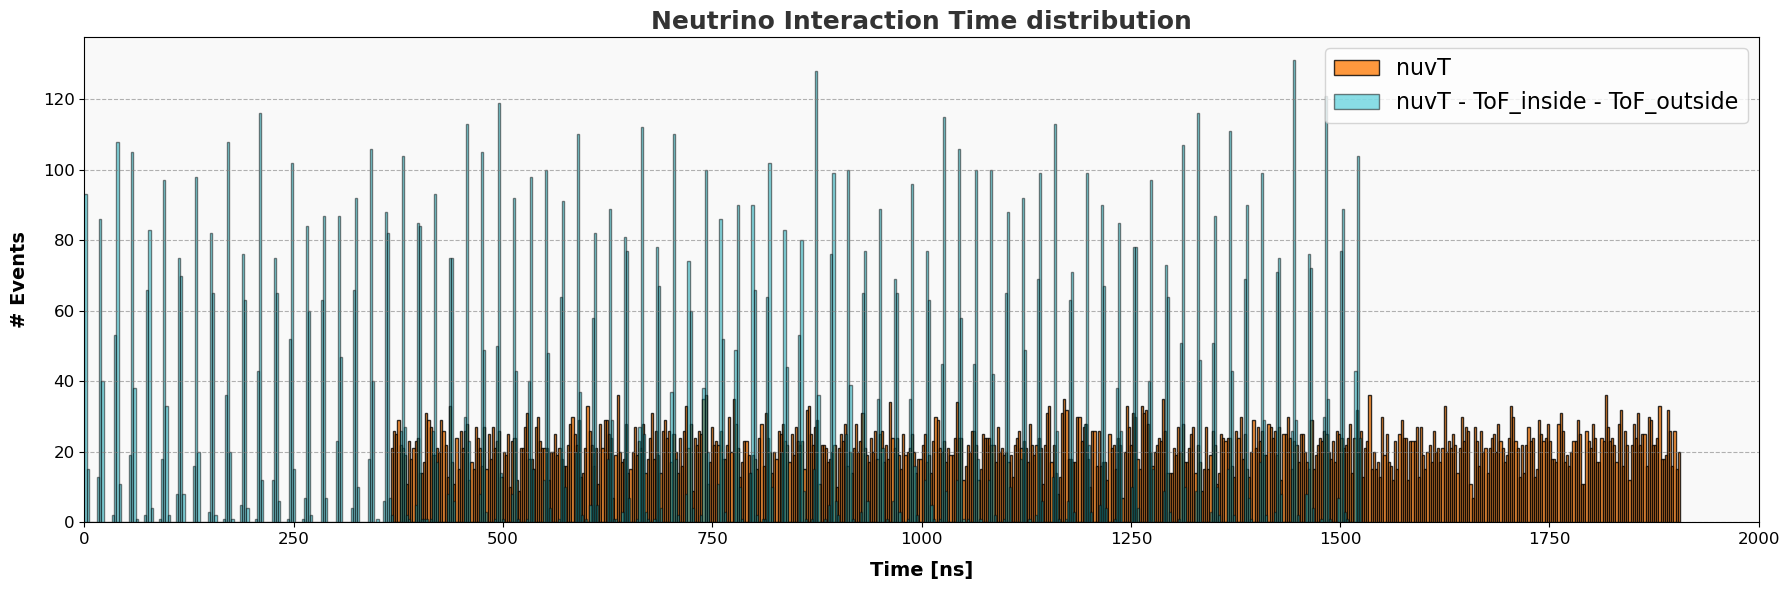

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# Assuming hit_nuvT, ToF_outside_set0, and ToF_inside are defined awkward arrays
# Calculate the difference and flatten it
#difference = np.mod(ak.flatten(nuvT - ToF_inside - ToF_outside), 19)


# Calculate the standard deviation
std_dev = np.std(nuvT)
std_dev2 = np.std(nuvT_c + ToF_outside)

# Set up the plot
plt.figure(figsize=(18, 6))
plt.hist(nuvT, bins=600, color='#ff7f0e', edgecolor='black', alpha=0.8, label='nuvT')
plt.hist(nuvT_c, bins=600, color='#17becf', edgecolor='black', alpha=0.5, label='nuvT - ToF_inside - ToF_outside')

# Customize the title and labels
plt.title('Neutrino Interaction Time distribution', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time [ns]', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('# Events', fontsize=14, labelpad=10, fontweight='bold')

# Set axis limits
plt.xlim(0, 2000)
plt.ylim(0, None)

# Enhance the grid and axis appearance
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a light background color for the plot area to add contrast
plt.gca().set_facecolor('#f9f9f9')

# Add a legend
plt.legend(fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


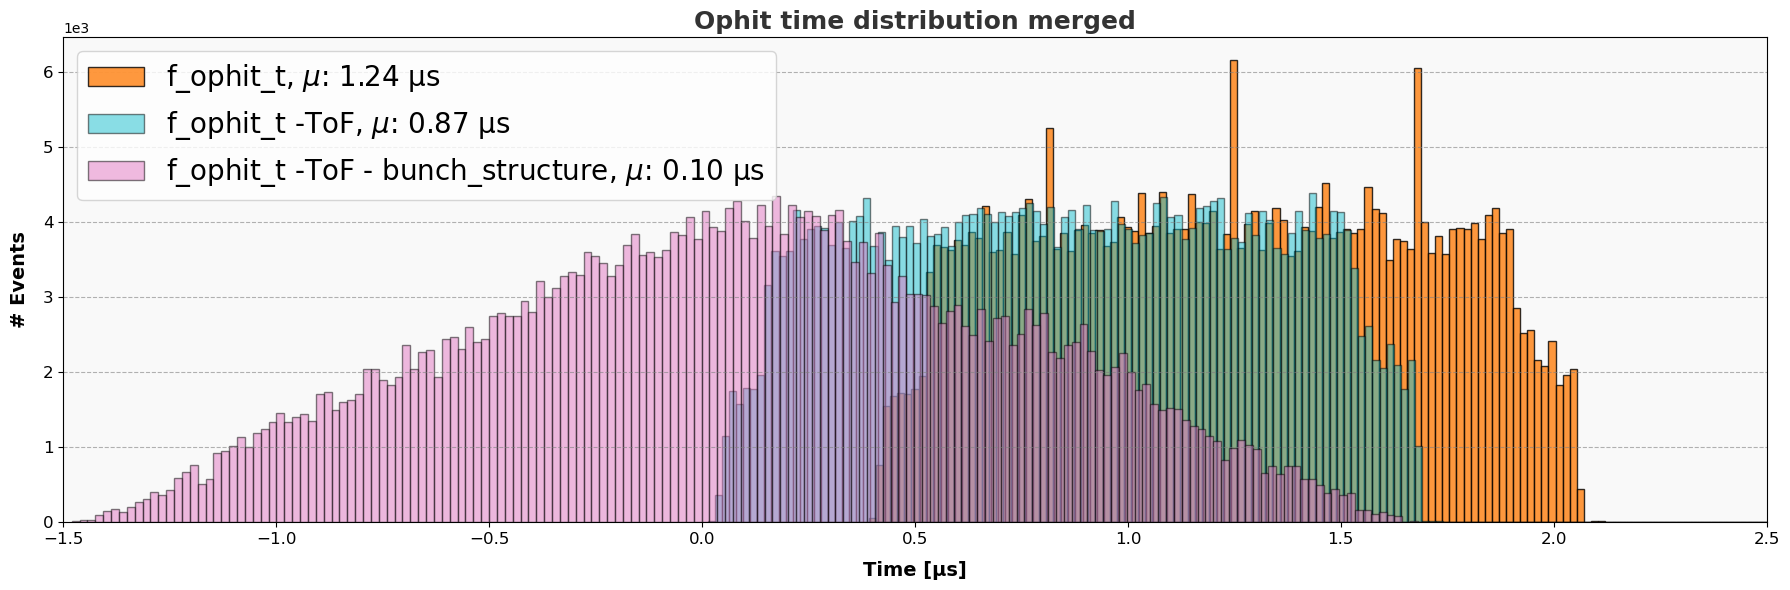

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# Assuming hit_nuvT, ToF_outside_set0, and ToF_inside are defined awkward arrays

flatten = ak.flatten(f_ophit_t_first10,axis=None)
flatten1 = ak.flatten(f_ophit_t_c_1_first10/1000,axis=None)
flatten2 = ak.flatten(f_ophit_t_c_2_first10/1000,axis=None)

# Calculate the standard deviation
std_dev = np.mean(flatten)
std_dev1 = np.mean(flatten1)
std_dev2 = np.mean(flatten2)

# Set up the plot
plt.figure(figsize=(18, 6))
plt.hist(flatten, bins=200, color='#ff7f0e', edgecolor='black', alpha=0.8, label=f'f_ophit_t, $\mu$: {std_dev:.2f} μs')  # Azul
plt.hist(flatten1, bins=200, color='#17becf', edgecolor='black', alpha=0.5, label=f'f_ophit_t -ToF, $\mu$: {std_dev1:.2f} μs')  # Verde
plt.hist(flatten2, bins=250, color='#e377c2', edgecolor='black', alpha=0.5, label=f'f_ophit_t -ToF - bunch_structure, $\mu$: {std_dev2:.2f} μs')  # Púrpura


# Customize the title and labels
plt.title('Ophit time distribution merged', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time [µs]', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('# Events', fontsize=14, labelpad=10, fontweight='bold')

# Set axis limits
plt.xlim(-1.5, 2.5)
plt.ylim(0, None)

# Enhance the grid and axis appearance
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  # Forces scientific notation on the y-axis

# Add a light background color for the plot area to add contrast
plt.gca().set_facecolor('#f9f9f9')

# Add a legend
plt.legend(fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()


The BNB is created by extracting protons from the Booster accelerator at Fermilab and impacting them on a beryllium target. The time structure of the delivered proton beam consists of a series of 81 bunches, each about 1.3 ns wide and 19 ns apart, defining a spill length of 1.6 µs

## 2. PE and time matrix

**With the complete data it takes ~ 14min**

In [26]:
pe_matrix, time_matrix = process_photoelectrons(f_ophit_PE_first10, f_ophit_ch_first10, f_ophit_t_c_1_first10)

In [27]:
# Save the matrices to a CSV file
np.savetxt("saved_archives/pe_matrix_&_time_matrix/pe_matrix_c_1_first10.csv", pe_matrix, delimiter=",")
np.savetxt("saved_archives/pe_matrix_&_time_matrix/time_matrix_c_1_first10.csv", time_matrix, delimiter=",")

In [28]:
# Convert awkward arrays to Arrow tables
ophit_variables_y = pa.Table.from_pydict({
    'nuvX': ak.to_list(nuvX),
    'nuvZ': ak.to_list(nuvZ),
    'nuvT_c': ak.to_list(nuvT_c),
    'nuvT_c_bunch': ak.to_list(nuvT_c_bunch),
    'dEpromx': ak.to_list(dEpromx),
    'dEpromy': ak.to_list(dEpromy),
    'dEpromz': ak.to_list(dEpromz),
    'dEtpc': ak.to_list(dEtpc),
})

# Save to Parquet file
pq.write_table(ophit_variables_y, 'saved_archives/ophit_variables_y_c_1_first10_v2101.parquet')